### Load libraries

In [49]:
%matplotlib inline
import numpy as np
from numpy import random

import pandas as pd
import shap
import time
import sys
sys.path.append('../../wrapper')
shap.initjs()

import os
import glob
from collections import Counter
from datetime import datetime

from sklearn.preprocessing import label_binarize
from scipy import interp
from itertools import cycle
from sklearn.utils import shuffle

import sklearn
import sklearn.datasets
from sklearn import preprocessing, pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel, SelectPercentile
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import xgboost
import mglearn

from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, cohen_kappa_score
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report, auc
from sklearn.model_selection import train_test_split, cross_val_score

from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn

In [50]:
random_state=20

### Define functions

In [51]:
def encode_cate_attrs(data, cate_attrs):
    data = encode_edu_attrs(data)
    cate_attrs.remove('education')
    for i in cate_attrs:
        dummies_df = pd.get_dummies(data[i])
        dummies_df = dummies_df.rename(columns=lambda x: i+'_'+str(x))
        data = pd.concat([data,dummies_df],axis=1)
        data = data.drop(i, axis=1)
    return data
    

def encode_bin_attrs(data, bin_attrs):    
    for i in bin_attrs:
        data.loc[data[i] == 'no', i] = 0
        data.loc[data[i] == 'yes', i] = 1
    return data


def encode_edu_attrs(data):
    values = ["illiterate", "basic.4y", "basic.6y", "basic.9y", 
    "high.school",  "professional.course", "university.degree"]
    levels = range(1,len(values)+1)
    dict_levels = dict(zip(values, levels))
    for v in values:
        data.loc[data['education'] == v, 'education'] = dict_levels[v]
    return data

def fill_unknown(data, bin_attrs, cate_attrs, numeric_attrs):
    # fill_attrs = ['education', 'default', 'housing', 'loan']
    fill_attrs = []
    for i in bin_attrs+cate_attrs:
        if data[data[i] == 'unknown']['y'].count() < 500:
            # delete col containing unknown
            data = data[data[i] != 'unknown'] 
        else:
            fill_attrs.append(i)
    data = encode_cate_attrs(data, cate_attrs)
    data = encode_bin_attrs(data, bin_attrs)
#     data = trans_num_attrs(data, numeric_attrs)
    data['y'] = data['y'].map({'no': 0, 'yes': 1}).astype(int)
    for i in fill_attrs:     
        test_data = data[data[i] == 'unknown']
        testX = test_data.drop(fill_attrs, axis=1)
        train_data = data[data[i] != 'unknown']        
        trainY = train_data[i]
        trainX = train_data.drop(fill_attrs, axis=1)
        test_data[i] = train_predict_unknown(trainX, trainY, testX)
        data = pd.concat([train_data, test_data]) 
    return data


def train_predict_unknown(trainX, trainY, testX):
    forest = RandomForestClassifier(n_estimators=100, random_state=random_state)
    trainY=trainY.astype('int')
    forest = forest.fit(trainX, trainY)
    test_predictY = forest.predict(testX).astype(int)
    return pd.DataFrame(test_predictY,index=testX.index)
    
    
def preprocess_data():
    input_data_path = "/Users/lillian/Documents/graduation_project/datasets/bank-additional/bank-additional-full.csv"
    processed_data_path = '/Users/lillian/Documents/graduation_project/datasets/bank-additional/test.csv'
    print("Loading data...")
    data = pd.read_csv(input_data_path, sep=';')
    print("Preprocessing data...")
    numeric_attrs = ['age', 'duration', 'campaign', 'pdays', 'previous',
                     'emp.var.rate', 'cons.price.idx', 'cons.conf.idx',
                     'euribor3m', 'nr.employed',]
    bin_attrs = ['default', 'housing', 'loan']
    cate_attrs = ['poutcome', 'education', 'job', 'marital', 
                  'contact', 'month','day_of_week']
    data = shuffle(data, random_state=random_state)
    print(data.shape)
    data = fill_unknown(data, bin_attrs, cate_attrs, numeric_attrs)
    data.to_csv(processed_data_path, index=False)

In [13]:
def k_fold_cross_validation(X_trainval, y_trainval, params, K, randomise = False):
    X = X_trainval.index
    if randomise:    
        np.random.permutation(X)
    
    scores_training = []
    scores_valid = []
    for k in np.arange(K):
        # shuffle split
        train = [x for i, x in enumerate(X) if i % K != k]
        valid = [x for i, x in enumerate(X) if i % K == k]
        X_train = X_trainval.loc[train]
        y_train = y_trainval.loc[train]
        X_valid = X_trainval.loc[valid]
        y_valid = y_trainval.loc[valid]
        # undersampling on training set
        X_train_sampled, y_train_sampled = undersampling(X_train, y_train, 
                                                 RandomUnderSampler(random_state=48), 30)
        X_train_sampled = pd.DataFrame(X_train_sampled, columns=list(X_train))
        # train XGBoost model
        xgb_train = xgboost.DMatrix(X_train_sampled, label=y_train_sampled)
        xgb_valid = xgboost.DMatrix(X_valid, label=y_valid)
        
        xgb = xgboost.train(params, xgb_train, 100)
        xgb_pred_valid = xgb.predict(xgb_valid)
        scores_training.append(roc_auc_score(y_train_sampled, xgb.predict(xgb_train)))
        scores_valid.append(roc_auc_score(y_valid, xgb.predict(xgb_valid)))
    print("AUC score on training set: {:.3f}".format(np.mean(scores_training)))
    print("AUC score on valid set: {:.3f}".format(np.mean(scores_valid)))
    return np.mean(scores_valid)

In [62]:
def undersampling(X, y, sampler, r):
    C = Counter(np.array(y))
    second_class = C.most_common(2)[-1][1]
    major_class = C.most_common(1)[-1][1]
    
    ratio={0: second_class*r}
#     ratio={1: int(major_class/r)}
    print(C)
    uds = sampler
    uds.set_params(ratio=ratio, random_state=random_state)
    X_sampled, y_sampled = uds.fit_sample(X, y)
    print('X_resampled.shape: {}, y_resampled: {}'.format(X_sampled.shape, y_sampled.shape))
    print('y_resample:\n{}'.format(pd.Series(y_sampled).value_counts()))   
    return X_sampled, y_sampled

In [57]:
def categorize_samples(clf, pred, y_test):
    pred_tp = pd.DataFrame(y_test).reset_index(drop=True).index[(y_test==1) & (pred==1)].tolist()
    pred_fp = pd.DataFrame(y_test).reset_index(drop=True).index[(y_test==0) & (pred==1)].tolist()
    pred_pos = pd.DataFrame(y_test).reset_index(drop=True).index[(pred==1)].tolist()
    pred_fn = pd.DataFrame(y_test).reset_index(drop=True).index[(y_test==1) & (pred==0)].tolist()
    pred_tn = pd.DataFrame(y_test).reset_index(drop=True).index[(y_test==0) & (pred==0)].tolist()
    pred_neg = pd.DataFrame(y_test).reset_index(drop=True).index[(pred==0)].tolist()
    return pred_tp, pred_fp, pred_pos, pred_fn, pred_tn, pred_neg

In [ ]:
def combine_categorical_SHAP(df_test):
    df_test['contact'] = df_test['contact_cellular'] + df_test['contact_telephone']
    df_test['day_of_week'] = df_test['day_of_week_mon'] + df_test['day_of_week_tue'] + df_test['day_of_week_wed'] +df_test['day_of_week_thu'] + df_test['day_of_week_fri']
    df_test['job'] = df_test['job_admin.'] + df_test['job_blue-collar'] + df_test['job_entrepreneur'] + df_test['job_housemaid'] + df_test['job_management'] + df_test['job_retired']+ df_test['job_self-employed']+ df_test['job_services']+ df_test['job_student']+ df_test['job_technician'] + df_test['job_technician'] + df_test['job_unemployed']
    df_test['marital'] = df_test['marital_divorced'] + df_test['marital_married'] + df_test['marital_single']
    df_test['month'] = df_test['month_mar'] + df_test['month_apr'] + df_test['month_may'] +df_test['month_jun'] + df_test['month_jul'] + df_test['month_aug'] + df_test['month_sep'] + df_test['month_oct'] + df_test['month_nov'] + df_test['month_dec']
    df_test['poutcome'] = df_test['poutcome_failure'] + df_test['poutcome_success'] + df_test['poutcome_nonexistent']
    drop_attr = ['contact_cellular', 'contact_telephone', 'day_of_week_mon', 'day_of_week_tue', 'day_of_week_wed', 'day_of_week_thu', 'day_of_week_fri', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'month_mar', 'month_apr', 'month_may', 'month_jun', 'month_jul', 'month_aug', 'month_sep', 'month_oct', 'month_nov', 'month_dec', 'poutcome_failure', 'poutcome_success', 'poutcome_nonexistent']
    df_test = df_test.drop(drop_attr, axis=1)
    return df_test

In [60]:
def join_X_shap(df_shap, X_value, y_value, xgb_pred, xgb_pred_text):
    df_shap.columns = [str(col) + '_SHAP' for col in df_shap.columns]
    df_X_shap = X_value.reset_index(drop=True).join(df_shap)
    tmp2 = df_X_shap.join(pd.DataFrame(y_value, columns=['y']).reset_index(drop=True))
    tmp3 = tmp2.join(pd.DataFrame(xgb_pred.astype(int), columns=['predict_num']))
    tmp4 = tmp3.join(pd.DataFrame(xgb_pred_text.astype(str), columns=['predict']))
    tmp4.head()
    return tmp4

In [61]:
def append_conditions(tmp_df, xgb_prob_test):
    tmp_df['prob'] = xgb_prob_test
    tmp_df['condition'] = 'condition'
    tmp_df['condition'].loc[((tmp_df['y']==1) & (tmp_df['predict_num']==1))] = 'TP'
    tmp_df['condition'].loc[((tmp_df['y']==0) & (tmp_df['predict_num']==1))] = 'FP'
    tmp_df['condition'].loc[((tmp_df['y']==1) & (tmp_df['predict_num']==0))] = 'FN'
    tmp_df['condition'].loc[((tmp_df['y']==0) & (tmp_df['predict_num']==0))] = 'TN'
    tmp_df['condition_num'] = 'condition'
    tmp_df['condition_num'].loc[((tmp_df['y']==1) & (tmp_df['predict_num']==1))] = 1 #'TP'
    tmp_df['condition_num'].loc[((tmp_df['y']==0) & (tmp_df['predict_num']==1))] = 0 #'FP'   
    tmp_df['condition_num'].loc[((tmp_df['y']==1) & (tmp_df['predict_num']==0))] = 2 #'FN' 
    tmp_df['condition_num'].loc[((tmp_df['y']==0) & (tmp_df['predict_num']==0))] = 3 #'TN' 
    tmp_pos = tmp_df[(tmp_df['condition_num']==1) | (tmp_df['condition_num']==0)]
    return tmp_df, tmp_pos

### Preprocess bank marketing data

In [52]:
start_time = datetime.now()
preprocess_data()
end_time = datetime.now()
delta_seconds = (end_time - start_time).seconds

Loading data...
Preprocessing data...
(41188, 21)


In [3]:
raw = pd.read_csv("/Users/lillian/Documents/graduation_project/datasets/bank-additional/bank-additional-full.csv", sep=';')
data = pd.read_csv("/Users/lillian/Documents/graduation_project/datasets/bank-additional/test.csv", sep = ",")

In [4]:
data.describe()

age     education       default       housing          loan  \
count  40787.000000  40787.000000  40787.000000  40787.000000  40787.000000   
mean      39.978817      5.155295      0.000098      0.537328      0.151887   
std       10.402157      1.639345      0.009903      0.498611      0.358915   
min       17.000000      1.000000      0.000000      0.000000      0.000000   
25%       32.000000      4.000000      0.000000      0.000000      0.000000   
50%       38.000000      5.000000      0.000000      1.000000      0.000000   
75%       47.000000      7.000000      0.000000      1.000000      0.000000   
max       98.000000      7.000000      1.000000      1.000000      1.000000   

           duration      campaign         pdays      previous  emp.var.rate  \
count  40787.000000  40787.000000  40787.000000  40787.000000  40787.000000   
mean     258.329811      2.566112    962.725427      0.172874      0.080516   
std      259.269596      2.768103    186.293432      0.494863      1.570133   
min        0.000000      1.000000      0.000000      0.000000     -3.400000   
25%      102.000000      1.000000    999.000000      0.000000     -1.800000   
50%      180.000000      2.000000    999.000000      0.000000      1.100000   
75%      319.500000      3.000000    999.000000      0.000000      1.400000   
max     4918.000000     56.000000    999.000000      7.000000      1.400000   

            ...            month_mar     month_may     month_nov  \
count       ...         40787.000000  40787.000000  40787.000000   
mean        ...             0.013264      0.333905      0.100203   
std         ...             0.114405      0.471612      0.300275   
min         ...             0.000000      0.000000      0.000000   
25%         ...             0.000000      0.000000      0.000000   
50%         ...             0.000000      0.000000      0.000000   
75%         ...             0.000000      1.000000      0.000000   
max         ...             1.000000      1.000000      1.000000   

          month_oct     month_sep  day_of_week_fri  day_of_week_mon  \
count  40787.000000  40787.000000     40787.000000     40787.000000   
mean       0.017334      0.013779         0.190723         0.206438   
std        0.130514      0.116573         0.392876         0.404754   
min        0.000000      0.000000         0.000000         0.000000   
25%        0.000000      0.000000         0.000000         0.000000   
50%        0.000000      0.000000         0.000000         0.000000   
75%        0.000000      0.000000         0.000000         0.000000   
max        1.000000      1.000000         1.000000         1.000000   

       day_of_week_thu  day_of_week_tue  day_of_week_wed  
count     40787.000000     40787.000000     40787.000000  
mean          0.209135         0.196288         0.197416  
std           0.406696         0.397194         0.398054  
min           0.000000         0.000000         0.000000  
25%           0.000000         0.000000         0.000000  
50%           0.000000         0.000000         0.000000  
75%           0.000000         0.000000         0.000000  
max           1.000000         1.000000         1.000000  

[8 rows x 49 columns]

In [5]:
data.loc[data['pdays'] == 999, 'pdays'] = -99
data.describe()

age     education       default       housing          loan  \
count  40787.000000  40787.000000  40787.000000  40787.000000  40787.000000   
mean      39.978817      5.155295      0.000098      0.537328      0.151887   
std       10.402157      1.639345      0.009903      0.498611      0.358915   
min       17.000000      1.000000      0.000000      0.000000      0.000000   
25%       32.000000      4.000000      0.000000      0.000000      0.000000   
50%       38.000000      5.000000      0.000000      1.000000      0.000000   
75%       47.000000      7.000000      0.000000      1.000000      0.000000   
max       98.000000      7.000000      1.000000      1.000000      1.000000   

           duration      campaign         pdays      previous  emp.var.rate  \
count  40787.000000  40787.000000  40787.000000  40787.000000  40787.000000   
mean     258.329811      2.566112    -95.163263      0.172874      0.080516   
std      259.269596      2.768103     19.717559      0.494863      1.570133   
min        0.000000      1.000000    -99.000000      0.000000     -3.400000   
25%      102.000000      1.000000    -99.000000      0.000000     -1.800000   
50%      180.000000      2.000000    -99.000000      0.000000      1.100000   
75%      319.500000      3.000000    -99.000000      0.000000      1.400000   
max     4918.000000     56.000000     27.000000      7.000000      1.400000   

            ...            month_mar     month_may     month_nov  \
count       ...         40787.000000  40787.000000  40787.000000   
mean        ...             0.013264      0.333905      0.100203   
std         ...             0.114405      0.471612      0.300275   
min         ...             0.000000      0.000000      0.000000   
25%         ...             0.000000      0.000000      0.000000   
50%         ...             0.000000      0.000000      0.000000   
75%         ...             0.000000      1.000000      0.000000   
max         ...             1.000000      1.000000      1.000000   

          month_oct     month_sep  day_of_week_fri  day_of_week_mon  \
count  40787.000000  40787.000000     40787.000000     40787.000000   
mean       0.017334      0.013779         0.190723         0.206438   
std        0.130514      0.116573         0.392876         0.404754   
min        0.000000      0.000000         0.000000         0.000000   
25%        0.000000      0.000000         0.000000         0.000000   
50%        0.000000      0.000000         0.000000         0.000000   
75%        0.000000      0.000000         0.000000         0.000000   
max        1.000000      1.000000         1.000000         1.000000   

       day_of_week_thu  day_of_week_tue  day_of_week_wed  
count     40787.000000     40787.000000     40787.000000  
mean          0.209135         0.196288         0.197416  
std           0.406696         0.397194         0.398054  
min           0.000000         0.000000         0.000000  
25%           0.000000         0.000000         0.000000  
50%           0.000000         0.000000         0.000000  
75%           0.000000         0.000000         0.000000  
max           1.000000         1.000000         1.000000  

[8 rows x 49 columns]

### Drop unrelated columns

In [7]:
data_category = raw[['contact', 'day_of_week', 'job', 'marital', 'month', 'poutcome']]
data = data.drop(['duration', 'emp.var.rate', 'cons.price.idx', 'nr.employed', 'cons.conf.idx'], axis=1)
data.shape

(40787, 44)

In [8]:
data.head()

age  education  default  housing  loan  campaign  pdays  previous  \
0   33          7        0        1     1         4    -99         0   
1   36          5        0        1     1         1    -99         0   
2   35          6        0        0     0         8    -99         0   
3   51          7        0        0     0         6    -99         1   
4   31          5        0        1     1         1    -99         0   

   euribor3m  y       ...         month_mar  month_may  month_nov  month_oct  \
0      1.281  0       ...                 0          1          0          0   
1      4.856  0       ...                 0          1          0          0   
2      4.859  0       ...                 0          1          0          0   
3      4.076  0       ...                 0          0          1          0   
4      4.963  0       ...                 0          0          0          0   

   month_sep  day_of_week_fri  day_of_week_mon  day_of_week_thu  \
0          0                0                0                0   
1          0                0                0                0   
2          0                1                0                0   
3          0                0                0                1   
4          0                0                0                0   

   day_of_week_tue  day_of_week_wed  
0                0                1  
1                1                0  
2                0                0  
3                0                0  
4                0                1  

[5 rows x 44 columns]

In [9]:
X = data.drop(['y'], axis=1)
y = data.y

### Split data into train/val/test with ratio 60/20/20

In [12]:
X_trainval, X_test, y_trainval, y_test=train_test_split(X, y, test_size = 0.2, stratify = y, random_state = random_state)
X_train, X_valid, y_train, y_valid=train_test_split(X_trainval, y_trainval, test_size = 0.2, stratify = y_trainval, random_state = random_state)

In [16]:
X_trainval_sampled, y_trainval_sampled = undersampling(X_trainval, y_trainval, 
                                                 RandomUnderSampler(random_state=random_state), 1)
X_trainval_sampled = pd.DataFrame(X_trainval_sampled, columns=list(X_trainval))

Counter({0: 28954, 1: 3675})
X_resampled.shape: (7350, 43), y_resampled: (7350,)
y_resample:
1    3675
0    3675
dtype: int64


### Build XGBoost model

In [19]:
xgb_trainval = xgboost.DMatrix(X_trainval_sampled, label=y_trainval_sampled)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

params = {'max_depth':3, 'n_estimators':100,
          'objective': "binary:logistic",
          'early_stopping_rounds':10, 
          'gamma': 0.9, 
          'learning_rate': 0.1,
          "base_score": np.mean(y_trainval_sampled),
          "eval_metric": "logloss",
          "silent":1}#,

xgb = xgboost.train(params, xgb_trainval, 100)
xgb_pred_test = np.where(xgb.predict(xgb_test)>0.5, 1, 0)
xgb_pred_text_test = np.where(xgb.predict(xgb_test)>0.5, 'Yes', 'No')
xgb_prob_test = xgb.predict(xgb_test)

In [20]:
print("AUC score on training set: {:.3f}".format(roc_auc_score(y_trainval_sampled, xgb.predict(xgb_trainval))))
print("AUC score on test set: {:.3f}".format(roc_auc_score(y_test, xgb.predict(xgb_test))))

confusion_matrix(y_test, xgb_pred_test)

AUC score on training set: 0.817
AUC score on test set: 0.810


array([[6113, 1126],
       [ 311,  608]])

### Comupted SHAP explanation values

In [66]:
explainer = shap.TreeExplainer(xgb)
shap_xgb_trainval = explainer.shap_values(X_trainval_sampled)
shap_xgb_test = explainer.shap_values(X_test)

In [67]:
df_shap_test = pd.DataFrame(shap_xgb_test , columns = list(X_test))
df_shap_test = combine_categorical_SHAP(df_shap_test)

In [68]:
drop_attr = ['contact_cellular', 'contact_telephone', 'day_of_week_mon', 'day_of_week_tue', 'day_of_week_wed', 'day_of_week_thu', 'day_of_week_fri', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_technician', 'job_unemployed', 'marital_divorced', 'marital_married', 'marital_single', 'month_mar', 'month_apr', 'month_may', 'month_jun', 'month_jul', 'month_aug', 'month_sep', 'month_oct', 'month_nov', 'month_dec', 'poutcome_failure', 'poutcome_success', 'poutcome_nonexistent']
X_test_cat = X_test.drop(drop_attr, axis=1)
X_test_cat = X_test_cat.join(data_category)
tmp_test = join_X_shap(df_shap_test, X_test_cat, y_test, xgb_pred_test, xgb_pred_text_test)
df_test, df_test_pos = append_conditions(tmp_test, xgb_prob_test)

In [69]:
def undersampling_test(X, y, sampler, r):
    C = Counter(np.array(y))
    second_class = C.most_common(2)[-1][1]
    major_class = C.most_common(1)[-1][1]
    
#     ratio={0: second_class}
    ratio={1: int(major_class/r)}
    print(C)
    uds = sampler
    uds.set_params(ratio=ratio, random_state=random_state)
    X_sampled, y_sampled = uds.fit_sample(X, y)
    print('X_resampled.shape: {}, y_resampled: {}'.format(X_sampled.shape, y_sampled.shape))
    print('y_resample:\n{}'.format(pd.Series(y_sampled).value_counts()))   
    return X_sampled, y_sampled

In [70]:
X_cat = X.drop(drop_attr, axis=1)
X_cat = X_cat.join(data_category)

In [71]:
X_cat.head()

age  education  default  housing  loan  campaign  pdays  previous  \
0   33          7        0        1     1         4    -99         0   
1   36          5        0        1     1         1    -99         0   
2   35          6        0        0     0         8    -99         0   
3   51          7        0        0     0         6    -99         1   
4   31          5        0        1     1         1    -99         0   

   euribor3m    contact day_of_week        job  marital month     poutcome  
0      1.281  telephone         mon  housemaid  married   may  nonexistent  
1      4.856  telephone         mon   services  married   may  nonexistent  
2      4.859  telephone         mon   services  married   may  nonexistent  
3      4.076  telephone         mon     admin.  married   may  nonexistent  
4      4.963  telephone         mon   services  married   may  nonexistent

In [72]:
n_feature = X_test_cat.shape[1]

In [73]:
pred_tp, pred_fp, pred_pos, pred_fn, pred_tn, pred_neg= categorize_samples(xgb, xgb_pred_test, y_test)

### The most importatn features ranking by the mean absolute SHAP values

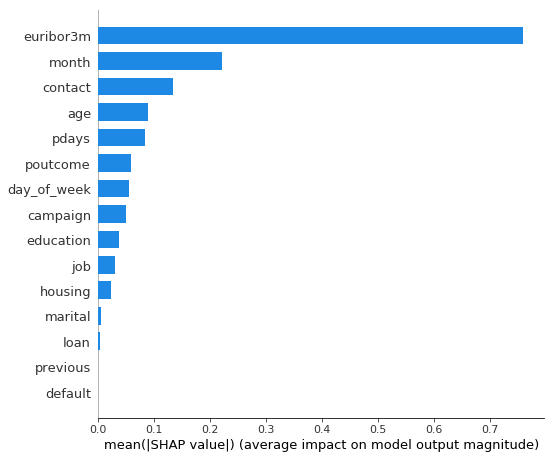

In [59]:
shap.summary_plot(df_test.iloc[:, n_feature:n_feature+n_feature], df_test.iloc[:, 0:n_feature], plot_type="bar")

### Plot the SHAP values for all the instances

In [41]:
shap.force_plot(explainer.expected_value, np.array(df_test.iloc[pred_pos, n_feature:n_feature+n_feature]), df_test.iloc[pred_pos, 0:n_feature])

In [42]:
subgroup = df_test[(df_test['age']>20) & (df_test['age']<30)]
subsamples = subgroup.sample(frac=1, replace=True)
shap.force_plot(explainer.expected_value, np.array(subsamples.iloc[:, n_feature:n_feature+n_feature]), subsamples.iloc[:, 0:n_feature])

In [63]:
subgroup = df_test[(df_test['age']>30) & (df_test['age']<40)]
subsamples = subgroup.sample(frac=1, replace=True)
shap.force_plot(explainer.expected_value, np.array(subsamples.iloc[:, n_feature:n_feature+n_feature]), subsamples.iloc[:, 0:n_feature])

### Plot scatter plot between feature values and the SHAP values

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           2.,    3.,    8.,    5.,    2.,    0.,   33.,    6.,    7.,
         102., 1566.]),
 array([-1.41945958, -1.34399117, -1.26852276, -1.19305435, -1.11758593,
        -1.04211752, -0.96664911, -0.8911807 , -0.81571229, -0.74024388,
        -0.66477546, -0.58930705, -0.51383864, -0.43837023, -0.36290182,
        -0.28743341, -0.21196499, -0.13649658, -0.06102817,  0.01444024,
         0.08990865]),
 <a list of 20 Patch objects>)

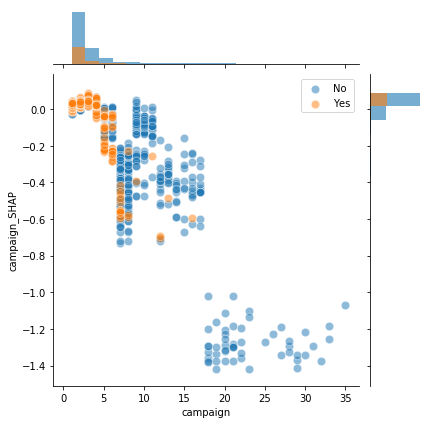

In [46]:
feature1 = 'campaign'
feature2 = 'campaign_SHAP'

cate_attrs = ['poutcome', 'education', 'job', 'marital', 
              'contact', 'month','day_of_week']
if feature1 in cate_attrs:
    le = preprocessing.LabelEncoder()
    le.fit(df_test[df_test['predict_num']==0][feature1])
    cat_neg = le.transform(df_test[df_test['predict_num']==0][feature1])
    cat_pos = le.transform(df_test[df_test['predict_num']==1][feature1])

### months
#     months = ["mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
#     mapping = {month: i for i, month in enumerate(months)}
#     cat_neg = df_test[df_test['predict_num']==0][feature1].map(mapping)  
#     cat_pos = df_test[df_test['predict_num']==1][feature1].map(mapping) 


kws = dict(s=70, linewidth=.7, edgecolor="w", alpha=0.5)

p = seaborn.JointGrid(
    x = df_test[df_test['predict_num']==0][feature1],
#     x = cat_neg,
    y = df_test[df_test['predict_num']==0][feature2])
#     ylim = (df_test.iloc[:, 20:40].min().min(), df_test.iloc[:, 20:40].max().max()) )

p = p.plot_joint(
    plt.scatter, **kws, label='No'
    )
p.x = df_test[df_test['predict_num']==1][feature1]
# p.x = cat_pos
p.y = df_test[df_test['predict_num']==1][feature2]
p.plot_joint(plt.scatter, marker='o',  **kws, label='Yes')

# p.ax_joint.set_xticklabels(["mar", "mar", "may", "jul", "sep", "nov", "dec"])
plt.legend()


if feature1 in cate_attrs:
    print(np.min(cat_neg), np.max(cat_neg))
    p.ax_marg_x.hist(
        cat_neg,
        alpha = 0.6,
        bins=20,
        range = (np.min(cat_neg), np.max(cat_neg))
        )
    p.ax_marg_x.hist(
        cat_pos,
        alpha = 0.6,
        bins=20,
        range = (np.min(cat_neg), np.max(cat_neg))
        )
else:
    
    p.ax_marg_x.hist(
        df_test[df_test['predict_num']==0][feature1],
        alpha = 0.6,
        bins=20,
        range = (np.min(df_test[feature1]), np.max(df_test[feature1]))
        )


    p.ax_marg_x.hist(
        df_test[df_test['predict_num']==1][feature1],
        alpha = 0.6,
        bins=20,
        range = (np.min(df_test[feature1]), np.max(df_test[feature1]))
        )

p.ax_marg_y.hist(
    df_test[df_test['predict_num']==0][feature2],
    orientation = 'horizontal',
    alpha = 0.6,
    bins=20,
    range = (np.min(df_test[feature2]), np.max(df_test[feature2]))
    )


p.ax_marg_y.hist(
    df_test[df_test['predict_num']==1][feature2],
    orientation = 'horizontal',
    alpha = 0.6,
    bins=20,
    range = (np.min(df_test[feature2]), np.max(df_test[feature2]))
)

Text(0,0.5,'SHAP values')

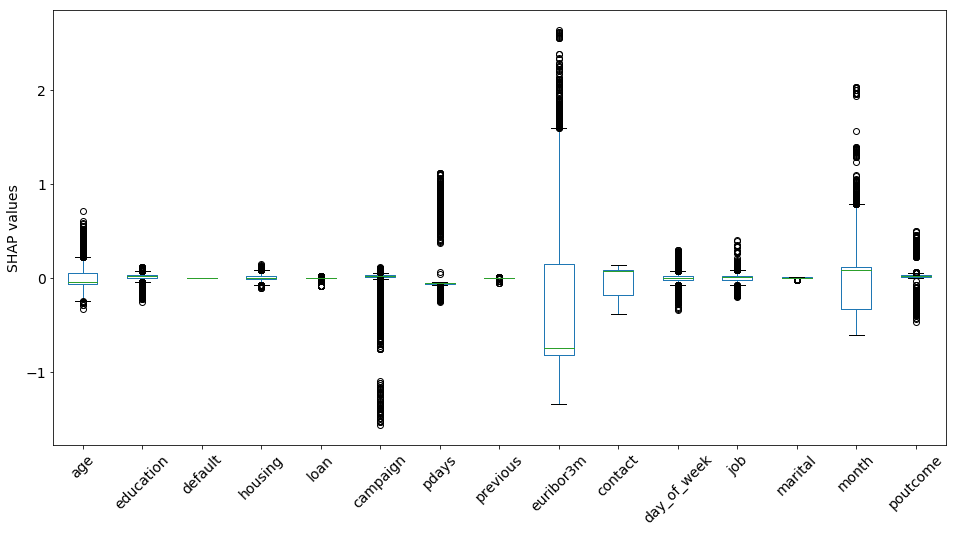

In [180]:
ax = df_test.iloc[:, n_feature:n_feature+n_feature].plot.box(figsize=(16,8))
plt.xticks(np.arange(1, n_feature+1), list(df_test.iloc[:, 0:n_feature]), rotation=45)
ax.set_ylabel('SHAP values')

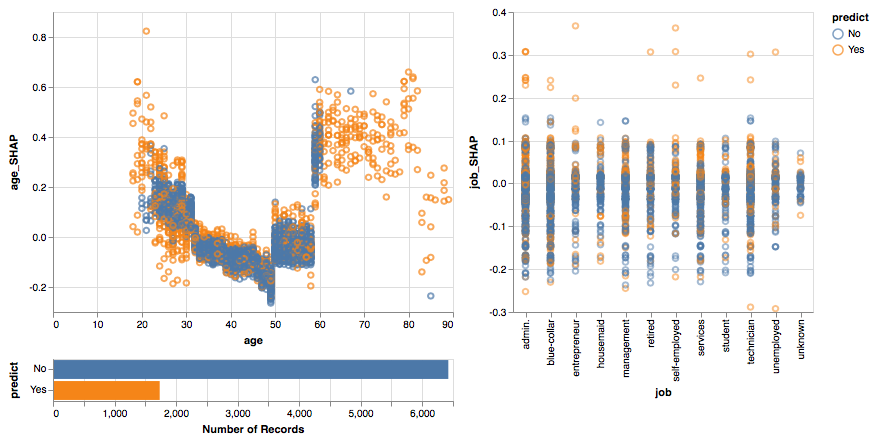

In [75]:
import altair as alt
from vega_datasets import data
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')
alt.themes.enable('opaque')

brush = alt.selection(type='interval')
palette = alt.Scale(domain=[0.0, 1.0],
                  range=["blue", "amber"])

# subsamples = df_test.sample(frac=0.01, replace=True)

points = alt.Chart().mark_point().encode(
    x='age',
    y='age_SHAP',
    color=alt.condition(brush, 'predict:N', alt.value('lightgrey'))#, scale=palette)
).add_selection(
    brush
)

bars = alt.Chart().mark_bar().encode(
    y='predict:N',
    color='predict:N',
    x='count(predict):Q'
).transform_filter(
    brush
)

base2 = alt.Chart(df_test).mark_point(opacity=0.5).encode(
     y = 'job_SHAP',
#     alt.Y('euribor3m_SHAP', scale=alt.Scale(domain=(-2, 1) ) ),
    color=alt.condition(brush, 'predict', alt.ColorValue('#D3D3D300')),#
).add_selection(
    brush
).properties(
    width=300,
    height=300
)

alt.vconcat(points, bars, data=df_test) | base2.encode(alt.X('job', scale=alt.Scale(zero=False )))  #
#[(df_test['age']>20) & (df_test['age']<30)]) 
#(alt.X('nr_employed', scale=alt.Scale(domain=(4500, 5000) ))) 
#.configure_axisX(labelFontSize=14).configure_axisY(labelFontSize=14)